In [19]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from root_numpy import root2array
import Constants as C
from WeightTool import WeightTool
from matplotlib.colors import LogNorm

from PlotTool import PlotTool
from Cuts import qratio, getQAB, qlayerCut

savedir = '../plots/cutsana/optimization/'

In [14]:
# Specify file paths
f_nue   = '../trees/NuGen_11068_Dec7_600files.root'
f_hecor = '../trees/Corsika_11362_Dec7_3462files.root'
f_lecor = '../trees/Corsika_11499_Dec7_500files.root'

# Specify branches to load
branches = ['NPE','Nch','ImpLF_zen','ImpLF_rchi2', 
            'nuE','NEvents','OneWeight',
            'honda2006_nue', 'sarcevic_std_nue',
            'cor_Weight','cor_DiplopiaWeight','cor_Polygonato',
            'cor_TimeScale',
            'passHESE','q_out0','q_out1','q_out2','q_in',
            'risetimelarge5','widthlarge5',
            'dhC_ndir_pulses','dhC_qdir_pulses',
            'hs_z_travel','totalQ',
            'log10(hs_q_tot_pulses)', 'hm_nhit_doms','hm_nhit_strings',
            'hm_nhit_doms/hm_nhit_strings', 'log10(hs_q_tot_pulses)/hm_nhit_doms',
            'StrNearly5[0]',
            #'Qearly5','tearly5','StrNearly5','DomNearly5',
            #'Qlarge5','risetimelarge5','widthlarge5','tlarge5',
            #'xlarge5','ylarge5','zlarge5',
            #'xearly5','yearly5','zearly5',
            #'StrNlarge5','DomNlarge5', 
            'rho_travel_q', 'rho_travel',
            't_onstring - t_largest',
            'q_onstring - q_largest',
            'tlarge5[0]-tearly5[0]',
            'tlarge - tearly', 'q_string', 'corsika_wcor'
            ]

# Some selection -- skip hese events and require NPE > 1k
sel = '(!passHESE && NPE > 1000)'
truth = '&&(nuE>0 && log10(nuE)>=6)'

# Load data
d_nue   = root2array(f_nue, treename="tree", branches=branches, selection=sel+truth)
d_hecor = root2array(f_hecor, treename="tree", branches=branches, selection=sel)
d_lecor = root2array(f_lecor, treename="tree", branches=branches, selection=sel)

# Select the outer events
d_nue = qlayerCut(d_nue, False, 0.8)
d_hecor = qlayerCut(d_hecor, False, 0.8)
d_lecor = qlayerCut(d_lecor, False, 0.8)

# Get the Weight Tool and weights
w_tool  = WeightTool()
w_E2    = w_tool.getAstroW(d_nue['nuE'], d_nue['OneWeight'], d_nue['NEvents'], C.nugen_nue_nfiles)
w_hecor = w_tool.getCorsikaW(d_hecor['cor_Weight'], 
                             d_hecor['cor_DiplopiaWeight'], 
                             d_hecor['cor_Polygonato'],
                             d_hecor['cor_TimeScale'],
                             C.cor_nfiles,
                             d_hecor['corsika_wcor']
                            )
w_lecor = w_tool.getCorsikaW(d_lecor['cor_Weight'], 
                             d_lecor['cor_DiplopiaWeight'], 
                             d_lecor['cor_Polygonato'],
                             d_lecor['cor_TimeScale'],
                             C.lowecor_nfiles,
                             d_lecor['corsika_wcor']
                            )

# Make data frame and add the weights
d_nue = pd.DataFrame(d_nue)
d_hecor = pd.DataFrame(d_hecor)
d_lecor = pd.DataFrame(d_lecor)

d_nue['w']   = pd.Series(w_E2)
d_hecor['w'] = pd.Series(w_hecor)
d_lecor['w'] = pd.Series(w_lecor)

# Now combine corsika into one set for plotting
d_cor = pd.concat([d_hecor, d_lecor])



In [15]:
# To make things easier for plotting define an info object

info = {'data' : [d_cor, d_nue],
        'lbl'  : [r'Atmos. $\mu$', r'Astro. $\nu_{e}$'],
        'col'  : ['r','b'],
        'w'    : ['w','w'],
        'ls'   : ['solid','solid']
       }

In [16]:
# Simple method to plot basic vars
def plot(info, var, xl, nbins, xmin, xmax, logy, ysf=1e-10):
    fig, ax = plt.subplots(ncols=1,figsize=(7,6))
    ymax = -9999
    for i in range(len(info['data'])):
        dt  = info['data'][i]
        col = info['col'][i]
        lbl = info['lbl'][i]
        ls  = info['ls'][i]
        w   = info['w'][i]
        bc, bins, p = plt.hist(dt[var].as_matrix(),
                               weights=dt[w].as_matrix(),
                               bins=nbins, range=(xmin,xmax),
                               color=col, label=lbl, lw=1.5,
                               histtype='step', ls = ls
                               )
        
        plt.xlabel(xl)
        plt.ylabel(C.lt_label)
        plt.tight_layout()
    
        if bc.max() > ymax:
            ymax = bc.max()
    
    if logy:
        ax.set_yscale('log')
        plt.ylim([ymax*ysf,5*ymax])
    plt.legend(loc='best',fontsize='medium')
    plt.grid()
    
# Also initialize the plot tool
pt = PlotTool()

# Method to plot waveform variables
def plotWF(info, var, Nwf, xl, nbins, xmin, xmax, logy, ysf=1e-10):
    
    for n in range(0,Nwf):
        fig, ax = plt.subplots(ncols=1,figsize=(7,6))
        ymax = -9999
        for i in range(len(info['data'])):
            dt  = info['data'][i]
            col = info['col'][i]
            lbl = info['lbl'][i]
            ls  = info['ls'][i]
            w   = info['w'][i]
            
            xval = dt[var].apply(lambda row: row[n])
            
            bc, bins, p = plt.hist(xval.as_matrix(),
                                   weights=dt[w].as_matrix(),
                                   bins=nbins, range=(xmin,xmax),
                                   color=col, label=lbl, lw=1.5,
                                   histtype='step', ls = ls
                                   )
        
            plt.xlabel(xl)
            plt.ylabel(C.lt_label)
            plt.tight_layout()
            plt.title('N = %i'%n)
            if bc.max() > ymax:
                ymax = bc.max()
    
        if logy:
            ax.set_yscale('log')
            plt.ylim([ymax*ysf,5*ymax])
        plt.legend(loc='best',fontsize='medium')
        plt.grid()

1077027.56698 Out: 721493.1483 (0.6699) In: 355534.4187 (0.3301)
0.338355554067 Out: 0.3016 (0.8913) In: 0.0368 (0.1087)


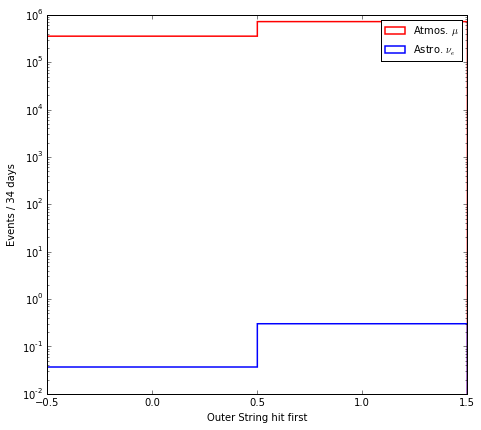

In [20]:
# The first thing that I had wanted to check was to require the first hit to be on 
# one of the outer strings.  So set that up and count how many events we have for 
# this case... Maybe it isn't good to cut here, but let's see

outer_strings = [1,2,3,4,5,6,
                13,21,30,40,50,
                59,67,74,
                73,72, 
                78,77,76,75,
                68,60,51,41,31,
                22,14,7]


fig,ax = plt.subplots(ncols=1,figsize=(7,6))
for i in range(len(info['data'])):
    dt  = info['data'][i]
    col = info['col'][i]
    lbl = info['lbl'][i]
    w   = info['w'][i]
    
    isouter = dt['StrNearly5[0]'].apply(lambda row: row in outer_strings)
    pt.ploth1(isouter.as_matrix(),
              dt[w].as_matrix(),
              'Outer String hit first',
              C.lt_label,
              lbl,
              2,-0.5,1.5,
              col, False, False)
    tot = sum(dt['w'])
    nout = sum(dt[ isouter ]['w'])
    nin  = sum(dt[ ~isouter ]['w'])
    print tot, "Out: %.4f (%.4f) In: %.4f (%.4f)"%(nout,nout/tot,nin,nin/tot)

ax.set_yscale("log")
plt.legend(loc='upper right',fontsize='medium')
plt.savefig(savedir+'firsthitout.png')

In [21]:
# Ok so let's remove the outer strings
def outerstringfirst(data):
    return data[ data['StrNearly5[0]'].apply(lambda row: row in outer_strings) ]

for i in range(len(info['data'])):
    info['data'][i] = outerstringfirst(info['data'][i])

rho-travel <  200
	 Atmos. $\mu$ Survived: 300584.5535 (0.42)
	 Astro. $\nu_{e}$ Survived: 0.2560 (0.85)
rho-travel <  250
	 Atmos. $\mu$ Survived: 416287.3765 (0.58)
	 Astro. $\nu_{e}$ Survived: 0.2980 (0.99)
rho-travel <  300
	 Atmos. $\mu$ Survived: 524661.6357 (0.73)
	 Astro. $\nu_{e}$ Survived: 0.2996 (0.99)
rho-travel <  350
	 Atmos. $\mu$ Survived: 619814.7548 (0.86)
	 Astro. $\nu_{e}$ Survived: 0.3006 (1.00)
rho-travel <  400
	 Atmos. $\mu$ Survived: 681481.9328 (0.94)
	 Astro. $\nu_{e}$ Survived: 0.3013 (1.00)


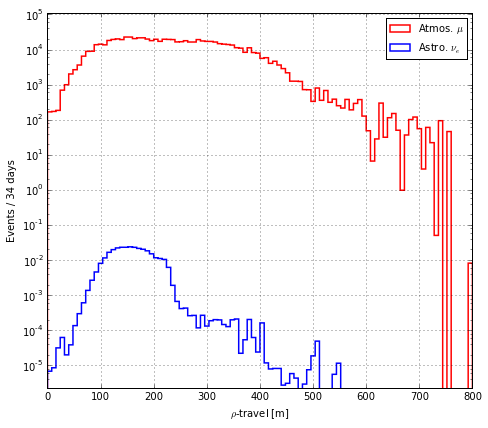

In [22]:
# A lot of the remaining events I saw in data are from corner clippers or
# are from events that travel through the sides of the detector. To get rid
# of the ones traveling through the side, let's see how rho-travel looks

# Plot rho travel
plot(info, 'rho_travel',r'$\rho$-travel [m]',100,0,800,True)
plt.savefig(savedir+'rhotravel.png')

# List some potential cuts and their impact
cutvals = [200, 250, 300, 350, 400]
for cval in cutvals:
    print "rho-travel < ", cval
    for i in range(len(info['data'])):
        dt = info['data'][i]
        lbl = info['lbl'][i]
        wcut = sum(dt[ dt['rho_travel'] < cval ][info['w'][i]])
        tot  = sum(dt[info['w'][i]])
        print "\t %s Survived: %.4f (%.2f)"%(lbl, wcut, wcut/tot)


In [23]:
# This is not as strong as the other requirement, but let's remove 
# around 23% background and 1% signal

def rhocut(dt, cutval):
    return dt[ dt['rho_travel'] < cutval ]

for i in range(len(info['data'])):
    info['data'][i] = rhocut(info['data'][i], 250)


z-travel >  400
	 Atmos. $\mu$ Survived: 406983.3068 (0.98)
	 Astro. $\nu_{e}$ Survived: 0.2980 (1.00)
z-travel >  300
	 Atmos. $\mu$ Survived: 177965.6070 (0.43)
	 Astro. $\nu_{e}$ Survived: 0.2973 (1.00)
z-travel >  200
	 Atmos. $\mu$ Survived: 115629.6790 (0.28)
	 Astro. $\nu_{e}$ Survived: 0.2966 (1.00)
z-travel >  150
	 Atmos. $\mu$ Survived: 87027.7347 (0.21)
	 Astro. $\nu_{e}$ Survived: 0.2958 (0.99)
z-travel >  100
	 Atmos. $\mu$ Survived: 53347.6642 (0.13)
	 Astro. $\nu_{e}$ Survived: 0.2950 (0.99)


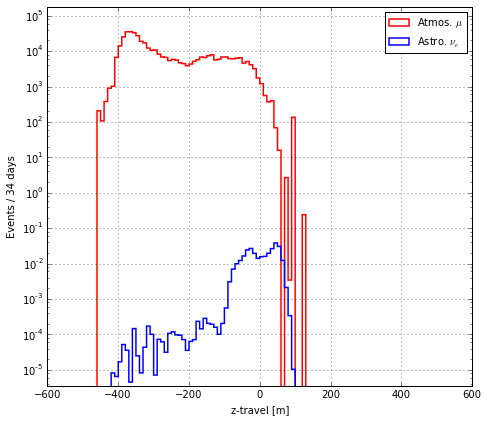

In [24]:
# So we can reduce background by 35% with a minimal impact to our signal.
# So remove those inner events and look at our next promising variable, 
# which is Z-travel

# Now plot z-travel
plot(info, 'hs_z_travel','z-travel [m]',100,-500,500,True)
plt.savefig(savedir+'ztravel.png')

# Now we can also print some info for different cut values
cutvals = [400, 300, 200, 150, 100]
for cval in cutvals:
    print "z-travel > ", cval
    for i in range(len(info['data'])):
        dt = info['data'][i]
        lbl = info['lbl'][i]
        wcut = sum(dt[ np.fabs(dt['hs_z_travel']) < cval ][info['w'][i]])
        tot  = sum(dt[info['w'][i]])
        print "\t %s Survived: %.4f (%.2f)"%(lbl, wcut, wcut/tot)


In [25]:
# So cutting on Z-travel really has a nice impact.  We can cut at 100 around
# the peak of the events and remove only a small fraction of events for signal
# while reducing Corsika to just 9% of the original

def zcut(dt, lowz, highz):
    return dt[ (dt['hs_z_travel'] < highz) & (dt['hs_z_travel'] > lowz)]

for i in range(len(info['data'])):
    info['data'][i] = zcut(info['data'][i], -100, 100)

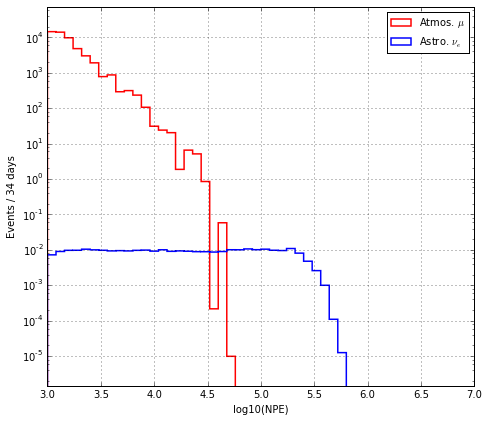

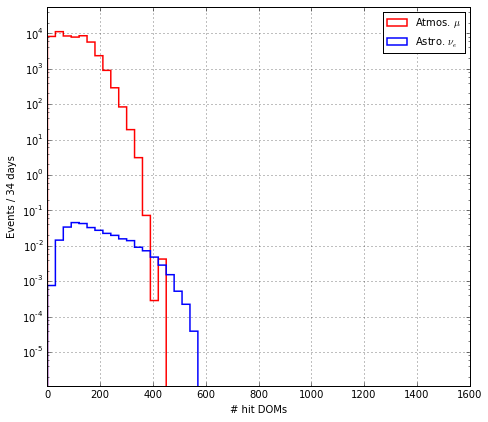

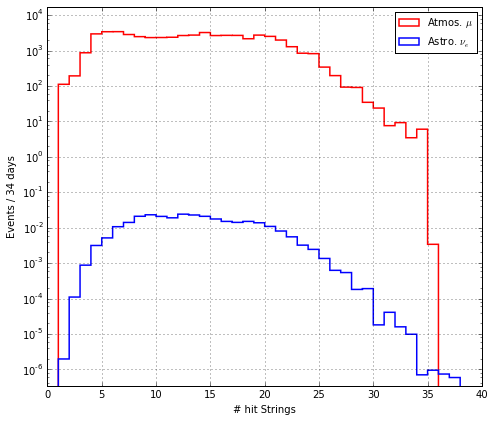

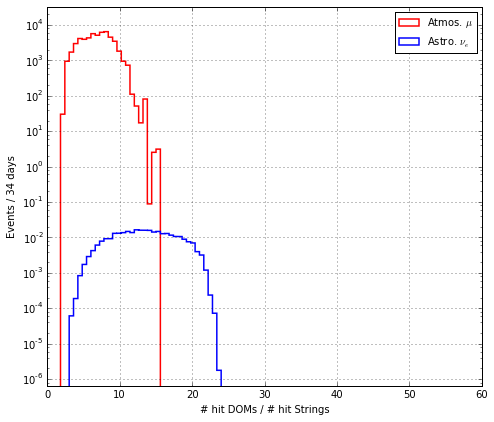

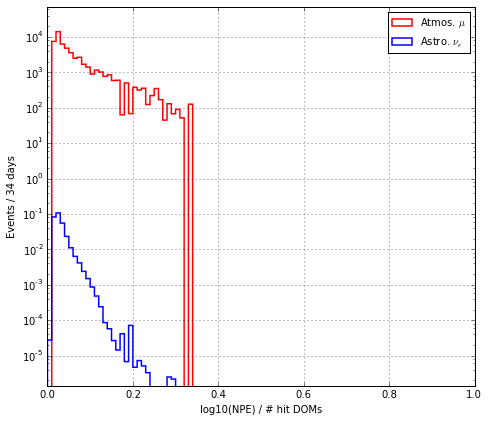

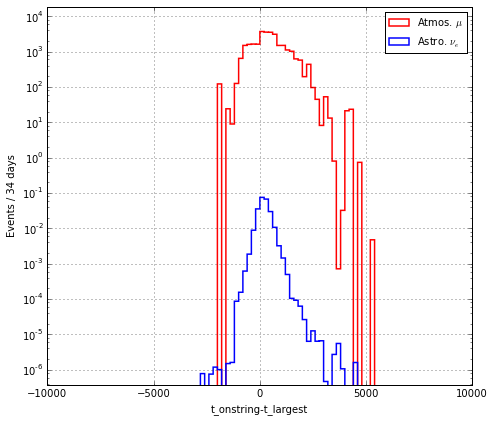

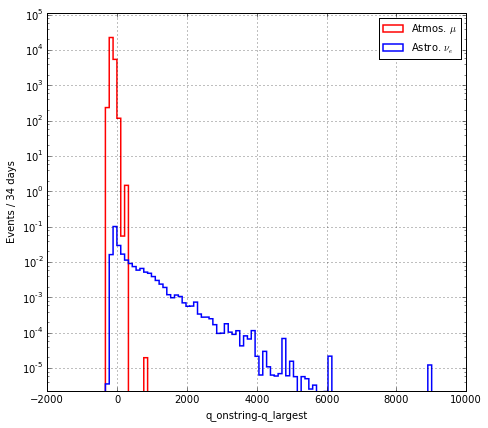

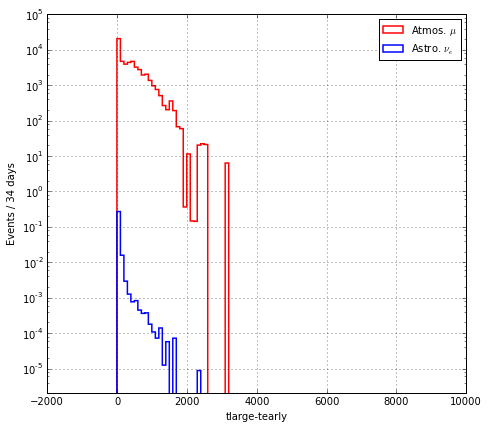

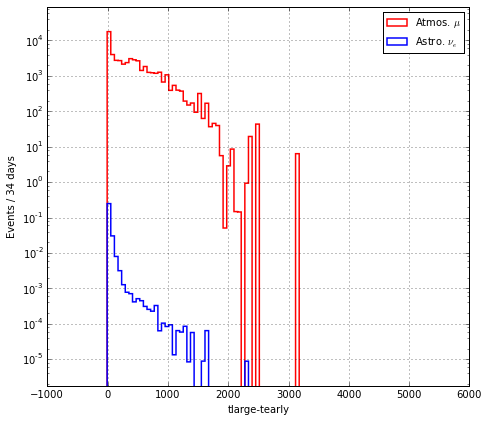

In [27]:
# Ok let's look at some of the remaining variables and see what things look like.

plot(info,'log10(hs_q_tot_pulses)','log10(NPE)',50,3,7,True)
plot(info,'hm_nhit_doms','# hit DOMs', 50, 0, 1500, True)
plot(info,'hm_nhit_strings','# hit Strings', 40, 0,40, True)
plot(info,'hm_nhit_doms/hm_nhit_strings','# hit DOMs / # hit Strings', 100, 0, 60, True)
plot(info,'log10(hs_q_tot_pulses)/hm_nhit_doms','log10(NPE) / # hit DOMs', 100, 0, 1, True)
plot(info,'t_onstring - t_largest', 't_onstring-t_largest', 100,-10000,10000, True)
plot(info,'q_onstring - q_largest', 'q_onstring-q_largest', 100,-1000,10000, True)
plot(info,'tlarge - tearly', 'tlarge-tearly', 100,-10,10000, True)
plt.savefig(savedir+'tlargeMtearly.png')
plot(info,'tlarge5[0]-tearly5[0]', 'tlarge-tearly', 100,-10,6000, True)

# Let's also look at some correlation plots and to do that
# just peal off the data
d_sig = info['data'][1]
d_bkg = info['data'][0]

# Plot constants
nbins = 30
xmin  = 0
xmax  = 30
ymin  = 3
ymax  = 7
zmin  = -1 #1e-4
zmax  = -1 #1e2

# Plot 2D for NPE vs Ndom/Nstr
#fig, ax = plt.subplots(ncols=2,figsize=(14,6))

#ax[0].set_title("Signal")
#pt.ploth2(d_sig['hm_nhit_doms/hm_nhit_strings'].as_matrix(),
#        d_sig['log10(hs_q_tot_pulses)'].as_matrix(),
#        d_sig['w'].as_matrix(), 
#        '# hit DOMs / # hit Strings',
#        'log10(NPE)',
#        C.lt_label,
#        nbins,xmin,xmax,ymin,ymax,zmin,zmax,
#        False,
#        ax[0])

#ax[1].set_title("Background")
#pt.ploth2(d_bkg['hm_nhit_doms/hm_nhit_strings'].as_matrix(),
#         d_bkg['log10(hs_q_tot_pulses)'].as_matrix(),
#         d_bkg['w'].as_matrix(), 
#         '# hit DOMs / # hit Strings',
#         'log10(NPE)',
#         C.lt_label,
#         nbins,xmin,xmax,ymin,ymax,zmin,zmax,
#         False,
#         ax[1])


In [28]:
# Checking some potential Cuts

def printcut(info, variable, cval, lessthan):
    print "Cut val", cval
    for i in range(len(info['data'])):
        dt = info['data'][i]
        lbl = info['lbl'][i]
        w = info['w'][i]
        tot = sum(dt[w])
        if lessthan:
            wcut = sum(dt[ dt[variable] < cval][w])
        else:
            wcut = sum(dt[ dt[variable] > cval][w])
        print "\t %s Surviving: %.4f (%.3f)"%(lbl, wcut, wcut/tot)
        
# Look first at tlarge - tearly -- This is really a statement about whether or not
# we have a track-lick or cascade like event
print "-------------------------------------------"
print "Checking cut value for tlarge - tearly"
cutvals = range(100,2000,100)
for cut in cutvals:
    printcut(info, 'tlarge - tearly', cut, True)



-------------------------------------------
Checking cut value for tlarge - tearly
Cut val 100
	 Atmos. $\mu$ Surviving: 21458.6835 (0.402)
	 Astro. $\nu_{e}$ Surviving: 0.2748 (0.931)
Cut val 200
	 Atmos. $\mu$ Surviving: 25575.3097 (0.479)
	 Astro. $\nu_{e}$ Surviving: 0.2878 (0.976)
Cut val 300
	 Atmos. $\mu$ Surviving: 29950.2326 (0.561)
	 Astro. $\nu_{e}$ Surviving: 0.2905 (0.985)
Cut val 400
	 Atmos. $\mu$ Surviving: 34095.7569 (0.639)
	 Astro. $\nu_{e}$ Surviving: 0.2917 (0.989)
Cut val 500
	 Atmos. $\mu$ Surviving: 38975.8839 (0.731)
	 Astro. $\nu_{e}$ Surviving: 0.2924 (0.991)
Cut val 600
	 Atmos. $\mu$ Surviving: 42130.3180 (0.790)
	 Astro. $\nu_{e}$ Surviving: 0.2932 (0.994)
Cut val 700
	 Atmos. $\mu$ Surviving: 44642.0191 (0.837)
	 Astro. $\nu_{e}$ Surviving: 0.2937 (0.996)
Cut val 800
	 Atmos. $\mu$ Surviving: 46742.5500 (0.876)
	 Astro. $\nu_{e}$ Surviving: 0.2940 (0.997)
Cut val 900
	 Atmos. $\mu$ Surviving: 48652.8437 (0.912)
	 Astro. $\nu_{e}$ Surviving: 0.2943 (0.998)

In [29]:
# Let's try cutting at 200 and look at other variables
def tlarge_early_cut(data):
    return data[ data['tlarge - tearly'] < 200 ]

for i in range(len(info['data'])):
    info['data'][i] = tlarge_early_cut(info['data'][i])


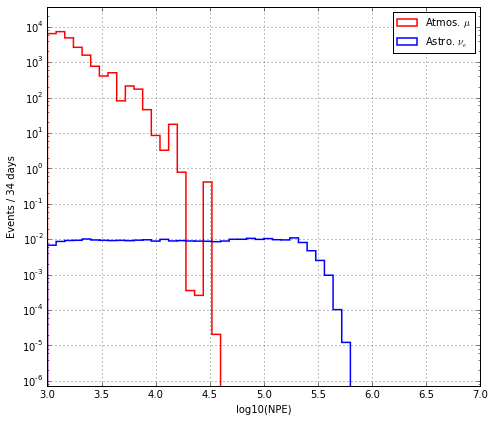

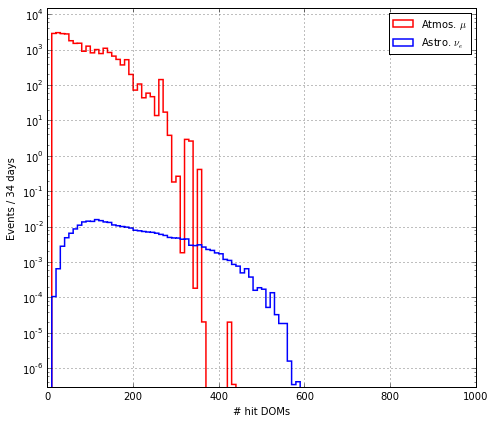

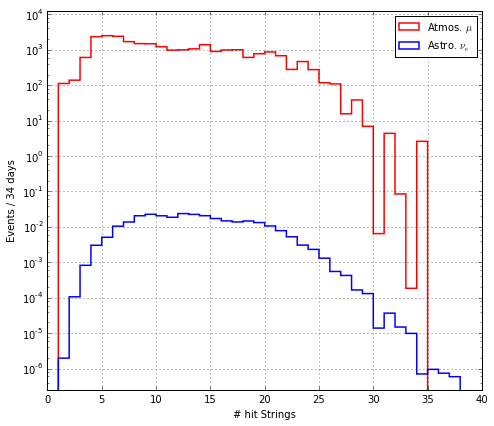

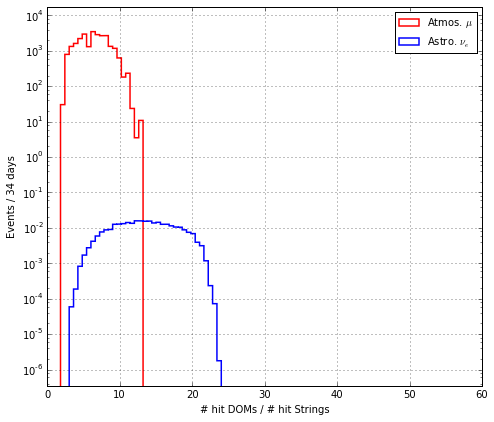

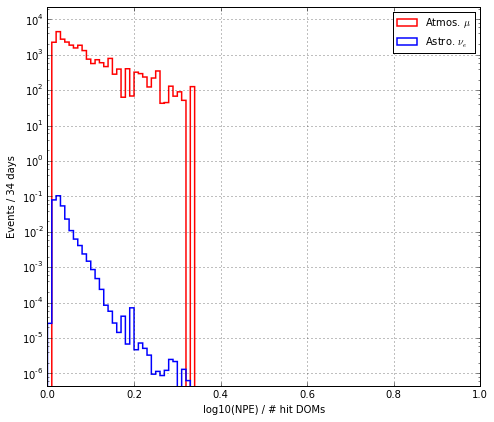

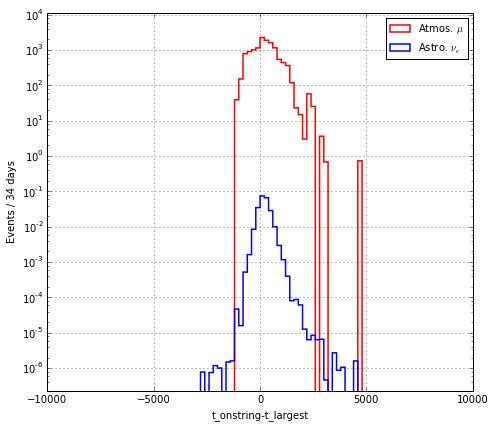

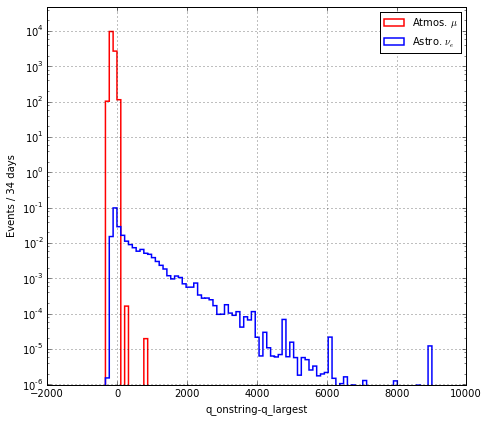

In [30]:
# Look back at figures again
plot(info,'log10(hs_q_tot_pulses)','log10(NPE)',50,3,7,True)
plt.savefig(savedir+'log10qtot.png')
plot(info,'hm_nhit_doms','# hit DOMs', 100, 0, 1000, True)
plt.savefig(savedir+'nhit_doms.png')
plot(info,'hm_nhit_strings','# hit Strings', 40, 0,40, True)
plt.savefig(savedir+'nhit_strings.png')
plot(info,'hm_nhit_doms/hm_nhit_strings','# hit DOMs / # hit Strings', 100, 0, 60, True)
plot(info,'log10(hs_q_tot_pulses)/hm_nhit_doms','log10(NPE) / # hit DOMs', 100, 0, 1, True)
plot(info,'t_onstring - t_largest', 't_onstring-t_largest', 100,-10000,10000, True)
plot(info,'q_onstring - q_largest', 'q_onstring-q_largest', 100,-1000,10000, True)


In [31]:
# Cut values for NPE
print "-------------------------------------------"
print "Checking cut value for NPE"
cutvals = np.arange(4.3,5.5,0.05)
for cut in cutvals:
    printcut(info, 'log10(hs_q_tot_pulses)', cut, False)
     


-------------------------------------------
Checking cut value for NPE
Cut val 4.3
	 Atmos. $\mu$ Surviving: 0.4119 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1387 (0.482)
Cut val 4.35
	 Atmos. $\mu$ Surviving: 0.4117 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1331 (0.462)
Cut val 4.4
	 Atmos. $\mu$ Surviving: 0.4114 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1279 (0.444)
Cut val 4.45
	 Atmos. $\mu$ Surviving: 0.4114 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1219 (0.424)
Cut val 4.5
	 Atmos. $\mu$ Surviving: 0.4112 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1164 (0.404)
Cut val 4.55
	 Atmos. $\mu$ Surviving: 0.0000 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1110 (0.385)
Cut val 4.6
	 Atmos. $\mu$ Surviving: 0.0000 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1059 (0.368)
Cut val 4.65
	 Atmos. $\mu$ Surviving: 0.0000 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.1001 (0.348)
Cut val 4.7
	 Atmos. $\mu$ Surviving: 0.0000 (0.000)
	 Astro. $\nu_{e}$ Surviving: 0.0946 (0.329)
Cut val 4.75
	 Atmos. $\mu$ Surviving: 0.00